In [1]:
import essentia.standard
import os
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt

from data import get_dataset
from model import load_model
from utils import post_config_hook

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
from utils import load_context_config
args = argparse.Namespace()

args.model_path = "./logs/audio/magnatagatune/clmr/1"
args.epoch_num = 1490
args.logistic_epochs = 0
args.mlp = 0
args = load_context_config(args)
args.reload = True

In [3]:
args.lin_eval = True  # first, pre-train, after that, lin. evaluation
args.n_gpu = torch.cuda.device_count()
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.at_least_one_pos = False
args.global_step = 0
args.current_epoch = 0


In [4]:
(train_loader, train_dataset, test_loader, test_dataset) = get_dataset(args)

### Linear / Supervised training, using segmented dataset ###
Num segments: 187060
Num tracks: 18706
[Train dataset (segments_22050)]: Loaded mean/std: -7.70555e-05, 0.17842068
### Linear / Supervised training, using segmented dataset ###
Num segments: 53290
Num tracks: 5329
[Test dataset (segments_22050)]: Loaded mean/std: -7.70555e-05, 0.17842068


In [5]:
model, _, scheduler = load_model(
    args, reload_model=args.reload, name=args.model_name
)

model = model.eval() # set in evaluation mode (dropout, bn, etc.)
# print(model)

### SampleCNN59049 ###
### RELOADING CLMR MODEL FROM CHECKPOINT 1490 ###
### Using Adam optimizer ###
### RELOADING CLMR OPTIMIZER FROM CHECKPOINT 1490 ###


In [6]:
def tensor_to_audio_sig(tensor):
    return tensor[0].permute(1,0).squeeze(1).cpu().numpy() # swap channel / samples

## Random input

In [7]:
## placeholder for the input images (None,59049,1)
input_audio = np.random.uniform(-1, 1, (1, 1, args.audio_length))
input_audio = torch.from_numpy(input_audio).float().to(args.device)

(-2952.4, 62000.4, -1.0999887794256211, 1.0999649971723557)

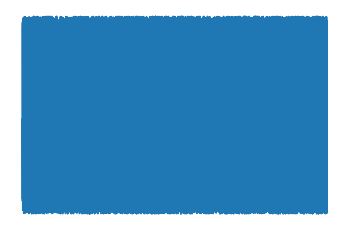

In [8]:
from scipy import signal

def plot_spectogram(x):
    f, t, Sxx = signal.spectrogram(x, args.sample_rate)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


x = tensor_to_audio_sig(input_audio)
plt.clf()
plt.plot(x)
plt.axis('off')

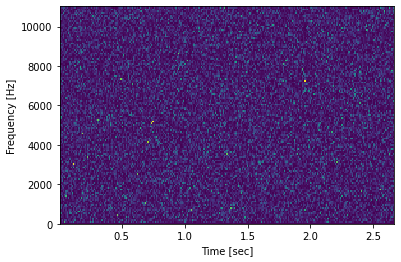

In [9]:
plot_spectogram(x)

In [10]:
## adjust model to first 7 layers
import torch.nn as nn

filter_model = nn.Sequential(*list(model.encoder.children())[:6])
filter_model = filter_model.eval()
filter_model

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 128, kernel_size=(3,), stride=(3,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride

In [11]:
class SaveFeatures():
    def __init__(self, args, module):
        self.args = args
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        # .detach().clone().requires_grad_(True).
#         self.features = output.to(self.args.device)
        self.features = torch.tensor(output, requires_grad=True, device=args.device)
    def close(self):
        self.hook.remove()


class FilterVisualizer():
    def __init__(self, args, model):
        self.args = args
        self.model = model.cuda().eval()

    def visualize(self, x, layer, filter_idx, lr=0.1, opt_steps=20):
        activations = SaveFeatures(self.args, self.model._modules.get(layer)[2])  # register hook
        optimizer = torch.optim.Adam([x], lr=lr)
        for n in range(opt_steps):
#             optimizer.zero_grad() # Reset the gradients
            self.model(x)
            loss = -activations.features[0, filter_idx].mean()
            loss.backward() # calculate the gradients of the pixel values with loss.backward()
            optimizer.step() # change the pixel values with optimizer.step().
        
        activations.close()
        return x

In [12]:
import librosa
import librosa.display
import os

if not os.path.exists("media/filters_waveform"):
    os.makedirs("media/filters_waveform")
    
if not os.path.exists("media/filters_spectrum"):
    os.makedirs("media/filters_spectrum")

In [13]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [111]:
def preprocess_waveform(a):
    a = train_loader.dataset.normalise_audio(torch.from_numpy(a.astype(np.float32)))
    a = torch.tensor(a, requires_grad=True)
    return a

def recreate_waveform(a):
    a = train_loader.dataset.denormalise_audio(a).clone().detach().cpu()
    return a

class CNNAudioVisualisation():
    """
        Produces a spectrum image that minimizes the loss of a convolution
        operation for a specific layer and filter, sorted by magnitude
    """
    def __init__(self, model, selected_layer, selected_filter, device):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        self.device = device
        # Create the folder to export images if not exists
        if not os.path.exists('./media/filters'):
            os.makedirs('./media/filters')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self, sample_length):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random waveform
        random_waveform = np.random.uniform(-0.5, 0.5, (1, 1, sample_length))
        
        # Process waveform and return variable (autograd)
        processed_waveform = preprocess_waveform(random_waveform)
        
        # Define optimizer for the waveform
        optimizer = torch.optim.Adam([processed_waveform], lr=0.1, weight_decay=1e-6)
        num_steps = 18 # 31
        for i in range(1, num_steps):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_waveform
            for index, layer in enumerate(self.model):
                x = x.to(self.device)
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            
            if i % 20 == 0:
                print("Iteration:", str(i), "Loss:", "{0:.2f}".format(loss.data))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            
            # Reconstruct waveform
            # self.created_waveform = processed_waveform
            self.created_wavefrom = recreate_waveform(processed_waveform)
#             # Save image
#             if i % 5 == 0:
#                 im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
#                     '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
#                 save_image(self.created_image, im_path)

In [112]:
sample_length = 729
fftsize = 729

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


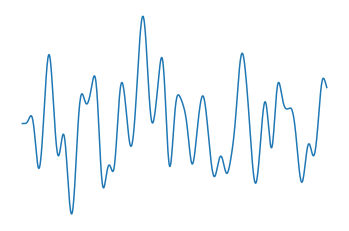

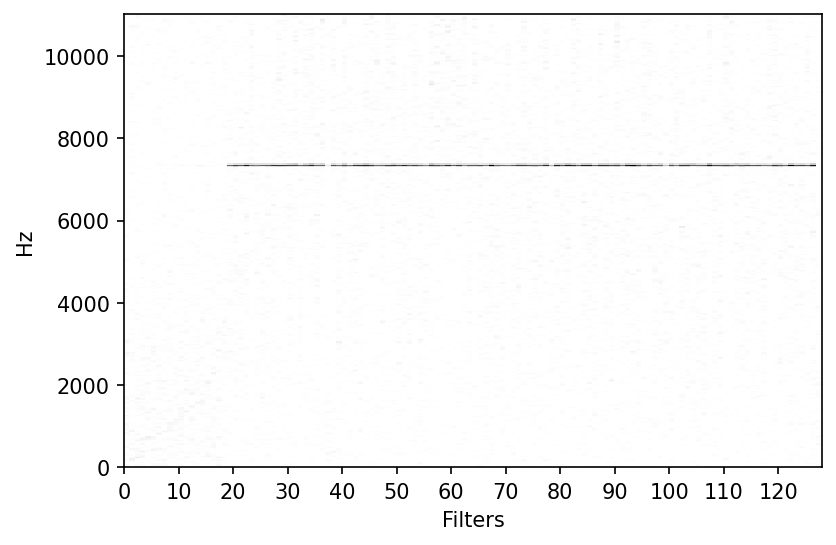

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


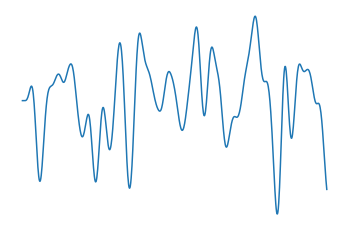

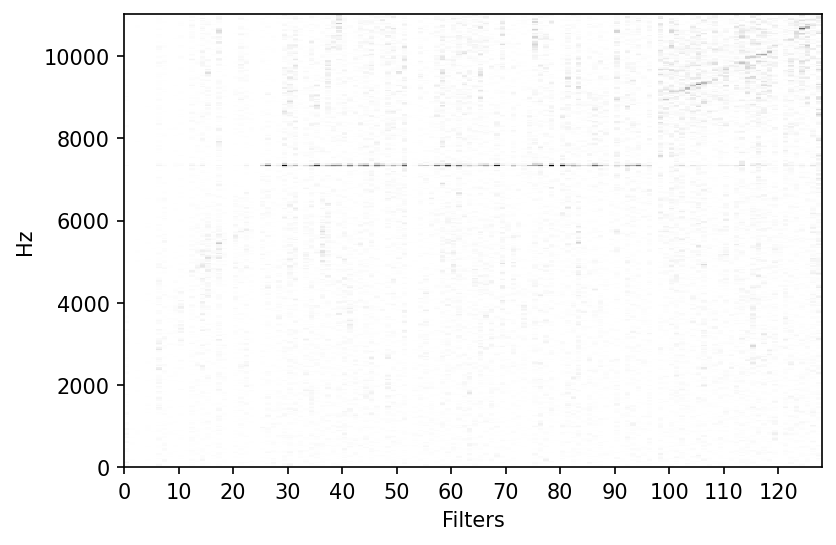

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


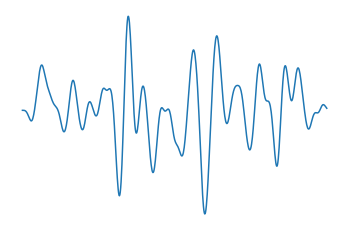

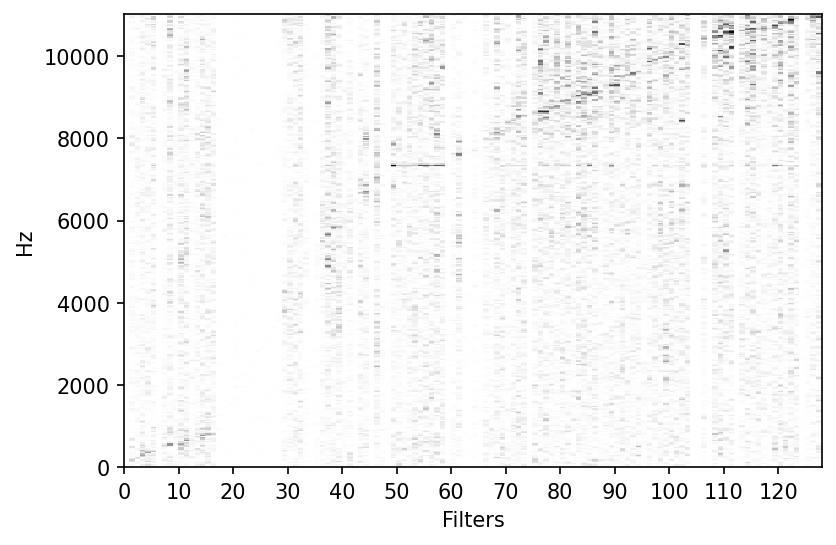

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


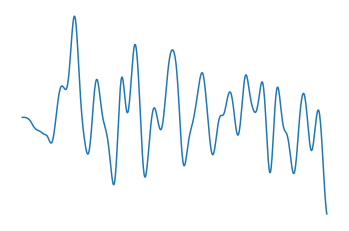

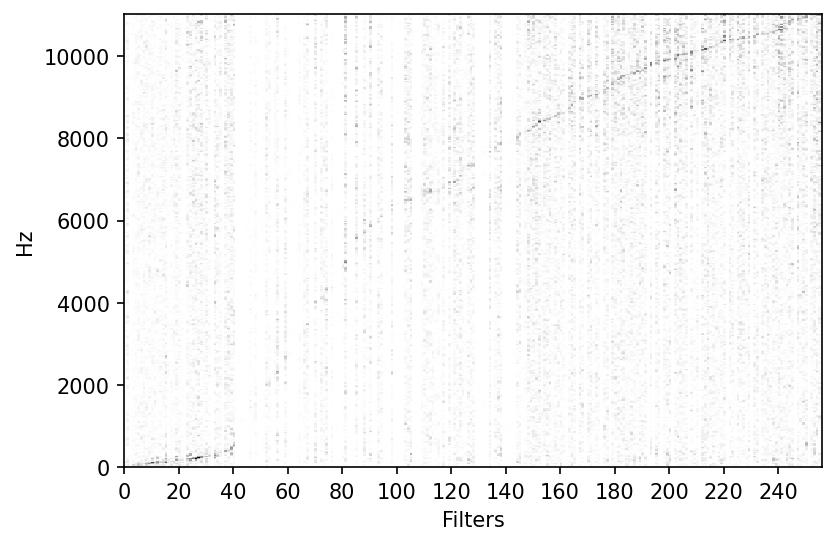

/home/jspijkervet/miniconda3/envs/clmr/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
filters = [128, 128, 128, 256, 256, 256]
num_layers = len(filter_model)

vs = FilterVisualizer(args, filter_model)
for idx, layer_idx in enumerate(range(num_layers)):
    
    num_filters = filters[idx]
    repetition = int((fftsize/2+1)/num_filters)

    fftzed = np.zeros((num_filters, int(fftsize/2+1)))
    for filter_idx in range(0, num_filters):
        # initialize optimization for layer and filter index
        vis = CNNAudioVisualisation(filter_model, layer_idx, filter_idx, args.device)
        
        # optimize with randomly generaetd waveform of segment length
        vis.visualise_layer_with_hooks(sample_length)
        created_audio = vis.created_wavefrom

        sample = tensor_to_audio_sig(created_audio)
        sample = sample - np.mean(sample) # remove dc

        # only save the last one to save space
        if filter_idx == num_filters-1:
            plt.clf()
            # low-pass sample to get dominant frequencies
            lowpass_sample = butter_lowpass_filter(sample, 600, args.sample_rate, order=6)
            plt.plot(lowpass_sample)
            plt.axis('off')
            plt.savefig(f"./media/filters/waveform_{layer_idx}_{filter_idx}.png")
        
        
        S = librosa.core.stft(sample, n_fft=fftsize, hop_length=fftsize, win_length=fftsize, center=False, window='hamming', dtype=np.complex256)
        
        # Calculate the spectrogram as the square of the complex magnitude of the STFT
        S = np.square(np.absolute(S))
#         log_S = librosa.power_to_db(S, ref=np.max)
#         log_S = np.log10(1+10*X)
        fftzed[filter_idx] = np.squeeze(S.astype(np.float32)) # log_S


    argmaxed = np.argmax(fftzed, axis=1)
    sort_idx = np.argsort(argmaxed)
    sorted_fft = fftzed[sort_idx,:]    
    
    plt.figure(dpi=150)
    plt.clf()
    sorted_fft = np.repeat(sorted_fft, repetition, axis=0)
    librosa.display.specshow(sorted_fft.T, cmap='gray_r', y_axis="linear") # log
    

#     plt.imshow(sorted_fft.T, cmap=plt.get_cmap("viridis"))
#     plt.gca().invert_yaxis()
#     plt.axis("off")
    plt.xticks(np.arange(0, num_filters*repetition, 20), [int(x/repetition) for x in np.arange(0, num_filters*repetition, 20)])
    plt.xlabel("Filters")
    plt.savefig(f"media/filters_spectrum/{layer_idx}.png")
    plt.show()
    

In [ ]:
import PIL
from PIL import Image
from IPython.display import display

list_im = [f"./media/filters_spectrum/{layer_idx}.png" for layer_idx in range(num_layers)]
imgs    = [ PIL.Image.open(i) for i in list_im ]
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

imgs_comb = PIL.Image.fromarray(imgs_comb)
# imgs_comb.save("./media/filters_spectrum_combined.png")
display(imgs_comb)

In [ ]:
# create sub-titles

fig, ax = plt.subplots(1, len(list_im), figsize=(100,100))
for idx, i in enumerate(imgs):
    ax[idx].imshow(i)
    ax[idx].axis("off")
    ax[idx].set_title(f"Layer {idx+1}", fontdict={'fontsize': 20, 'fontweight': 'bold'})

plt.axis("off")
plt.savefig("./media/filters_spectrum_combined.png", bbox_inches='tight', pad_inches=1)
plt.show()